(genai_01_basic_tutorial)=
# Deploying an LLM using MLRun
This notebook illustrates deploying an LLM using MLRun.

Since this tutorial is for illustrative purposes, it uses minimal resources &mdash; CPU and not GPU, and a small amount of data.

**In this tutorial:**
- [MLRun installation and configuration](#mlrun-installation-and-configuration)
- [Set up the vector database in the cluster](#set-up-the-vector-database-in-the-cluster)
- [Build the vector DB](#build-the-vector-db)
- [Serving the function](#serving-the-function)

**See also:**
- {ref}`model-monitoring-overview`
- {ref}`alerts-notifications`

<iframe width="560" height="315" src="https://www.youtube.com/embed/aoP__SaAO1M" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe><br><br>

## MLRun installation and configuration

Before running this notebook make sure the `mlrun` package is installed (`pip install mlrun`) and that you have configured the access to MLRun service. 

In [ ]:
# Install MLRun if not installed, run this only once. Restart the notebook after the install!
%pip install mlrun

In [1]:
import json
import mlrun

**Get or create a new project**

First create, load or use (get) an [MLRun Project](../projects/project.html). The {py:meth}`~mlrun.projects.get_or_create_project` method tries to load the project from the MLRun DB. If the project does not exist, it creates a new one.

In [2]:
project = mlrun.get_or_create_project("genai-tutorial-new")

> 2024-06-17 22:40:49,076 [info] Project loaded successfully: {'project_name': 'genai-tutorial-new'}


## Set up the vector database in the cluster 
These two steps imports a pre-defined dataset and load it into a vector database. Then the vector database is stored in the data layer of the cluster.

If you're not using Iguazio's Jupyter, download {download}`fetch-vectordb-data.py <src/fetch-vectordb-data.py>`.


The image for this step can be created using the following Dockerfile (contains MLRun and Chroma DB):
```
FROM mlrun/mlrun:1.6.3
RUN pip install chromadb==0.5.0 langchain==0.2.3 langchain-community==0.2.4 langchain-core==0.2.5 langchain-text-splitters==0.2.1 clean-text==0.6.0
```

In [3]:
# The model used is the free open-source PHI 2
MODEL_ID = "microsoft/phi-2"

# Define the dataset for the VectorDB
DATA_SET = mlrun.get_sample_path("data/genai-tutorial/labelled_newscatcher_dataset.csv")

# The location of the VectorDB files
CACHE_DIR = mlrun.mlconf.artifact_path
CACHE_DIR = (
    CACHE_DIR.replace("v3io://", "/v3io").replace("{{run.project}}", project.name)
    + "/cache"
)

Fetch the dataset for the Vector DB and save it in cluster:

In [4]:
fetch = project.set_function(
    name="fetch-vectordb-data",
    func="src/fetch-vectordb-data.py",
    kind="job",
    image="gcr.io/iguazio/mlrun-genai/mlrun-llm-demo-data:1.6.3",
)

In [5]:
fetch.save()

'db://genai-tutorial-new/fetch-vectordb-data:latest'

In [6]:
ret = project.run_function(
    name="fetch-vectordb-data-run",
    function="fetch-vectordb-data",
    handler="handler",
    params={"data_set": DATA_SET},
)

> 2024-06-17 22:40:51,371 [info] Storing function: {'name': 'fetch-vectordb-data-run', 'uid': 'c02105b2eb754580b1fb629c25158ab6', 'db': 'http://mlrun-api:8080'}
> 2024-06-17 22:40:51,626 [info] Job is running in the background, pod: fetch-vectordb-data-run-r8bhx
Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
Fetching pages: 100%|##########| 80/80 [00:19<00:00,  4.02it/s]
> 2024-06-17 22:42:28,297 [info] Dataset dowloaded and logged
> 2024-06-17 22:42:28,632 [info] To track results use the CLI: {'info_cmd': 'mlrun get run c02105b2eb754580b1fb629c25158ab6 -p genai-tutorial-new', 'logs_cmd': 'mlrun logs c02105b2eb754580b1fb629c25158ab6 -p genai-tutorial-new'}
> 2024-06-17 22:42:28,632 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cst-355.iguazio-cd1.com/mlprojects/genai-tutorial-new/jobs/monitor/c02105b2eb754580b1fb629c25158ab6/overview'}
> 2024-06-17 22:42:28,633 [info] Run execution

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
genai-tutorial-new,...25158ab6,0,Jun 17 22:41:58,completed,fetch-vectordb-data-run,v3io_user=nickkind=jobowner=nickmlrun/client_version=1.6.1mlrun/client_python_version=3.9.18host=fetch-vectordb-data-run-r8bhx,,data_set=https://s3.wasabisys.com/iguazio/data/genai-tutorial/labelled_newscatcher_dataset.csv,,vector-db-dataset


> 2024-06-17 22:42:33,114 [info] Run execution finished: {'status': 'completed', 'name': 'fetch-vectordb-data-run'}


In [7]:
ret.outputs

{'vector-db-dataset': 'store://artifacts/genai-tutorial-new/fetch-vectordb-data-run_vector-db-dataset@c02105b2eb754580b1fb629c25158ab6'}

## Build the vector DB

Build the vector DB in the data layer and load the data into it.

The image for this step can be created using the following Dockerfile (contains MLRun and Chroma DB):
```
FROM mlrun/mlrun:1.6.3
RUN pip install chromadb==0.5.0 langchain==0.2.3 langchain-community==0.2.4 langchain-core==0.2.5 langchain-text-splitters==0.2.1 clean-text==0.6.0
```

If you're not using Iguazio's Jupyter, download {download}`the build vector db <./src/build-vector-db.py>`.

In [8]:
# Build the vector DB using the image
build_vectordb = project.set_function(
    name="build-vectordb",
    func="src/build-vector-db.py",
    kind="job",
    image="gcr.io/iguazio/mlrun-genai/mlrun-llm-demo-data:1.6.3",
).apply(mlrun.auto_mount())

In [9]:
build_vectordb.save()

'db://genai-tutorial-new/build-vectordb:latest'

In [10]:
project.run_function(
    function="build-vectordb",
    inputs={"df": ret.outputs["vector-db-dataset"]},
    params={"cache_dir": CACHE_DIR},
    handler="handler_chroma",
)

> 2024-06-17 22:42:38,642 [info] Storing function: {'name': 'build-vectordb-handler-chroma', 'uid': '27068ddcaca249c482f15b92aced8bbf', 'db': 'http://mlrun-api:8080'}
> 2024-06-17 22:42:38,926 [info] Job is running in the background, pod: build-vectordb-handler-chroma-2sp77
> 2024-06-17 22:43:15,609 [info] downloading v3io:///projects/genai-tutorial-new/artifacts/fetch-vectordb-data-run/0/vector-db-dataset.csv to local temp file
Creating collection: 'my_news'
/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 83.1MiB/s]
> 2024-06-17 22:45:24,125 [info] Vector DB was created
> 2024-06-17 22:45:24,174 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 27068ddcaca249c482f15b92aced8bbf -p genai-tutorial-new', 'logs_cmd': 'mlrun logs 27068ddcaca249c482f15b92aced8bbf -p genai-tutorial-new'}
> 2024-06-17 22:45:24,174 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cst-355.iguazio-cd1.com/mlprojects/ge

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
genai-tutorial-new,...aced8bbf,0,Jun 17 22:43:15,completed,build-vectordb-handler-chroma,v3io_user=nickkind=jobowner=nickmlrun/client_version=1.6.1mlrun/client_python_version=3.9.18host=build-vectordb-handler-chroma-2sp77,df,cache_dir=/v3io/projects/genai-tutorial-new/artifacts/cache,,


> 2024-06-17 22:45:30,697 [info] Run execution finished: {'status': 'completed', 'name': 'build-vectordb-handler-chroma'}


## Serving the function

The image for this step can be created using the following Dockerfile (contains Chroma DB, Transformers, TF and PyTorch):

```
FROM mlrun/mlrun:1.6.3
RUN pip install chromadb==0.5.0 transformers==4.41.2 tensorflow==2.16.1 torch
```

If you're not using Iguazio's Jupyter, download {download}`serving.py <./src/serving.py>`.
Now you can deploy the the Nuclio function that serves the LLM:

In [15]:
serve_func = project.set_function(
    name="serve-llm",
    func="src/serving.py",
    image="gcr.io/iguazio/mlrun-genai/llmserve:1.6.3",
    kind="nuclio",
).apply(mlrun.auto_mount())

# Transferring the model and VectorDB path to the serving functions
serve_func.set_envs(env_vars={"MODEL_ID": MODEL_ID, "CACHE_DIR": CACHE_DIR})

# Since the model is stored in memory, use only 1 replica and and one worker
# Since this is running on CPU only, inference might take ~1 minute (increasing timeout)
serve_func.spec.min_replicas = 1
serve_func.spec.max_replicas = 1
serve_func.with_http(worker_timeout=120, gateway_timeout=150, workers=1)
serve_func.set_config("spec.readinessTimeoutSeconds", 1200)

> 2024-06-17 22:51:29,928 [warning] Adding HTTP trigger despite the default HTTP trigger creation being disabled


In [16]:
serve_func = project.deploy_function(function="serve-llm")

> 2024-06-17 22:51:30,191 [info] Starting remote function deploy
2024-06-17 22:51:30  (info) Deploying function
2024-06-17 22:51:30  (info) Building
2024-06-17 22:51:30  (info) Staging files and preparing base images
2024-06-17 22:51:30  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-06-17 22:51:30  (info) Building processor image
2024-06-17 22:56:15  (info) Build complete
2024-06-17 22:57:12  (info) Function deploy complete
> 2024-06-17 22:57:12,371 [info] Successfully deployed function: {'internal_invocation_urls': ['nuclio-genai-tutorial-new-serve-llm.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['genai-tutorial-new-serve-llm.default-tenant.app.cst-355.iguazio-cd1.com/']}


### Test Serving Function

In [17]:
body = {
    "question": "What are some new developments in space travel?",
    "topic": "science",
}

In [18]:
resp = serve_func.function.invoke("/", body=json.dumps(body))

> 2024-06-17 22:57:31,894 [info] Invoking function: {'method': 'POST', 'path': 'http://nuclio-genai-tutorial-new-serve-llm.default-tenant.svc.cluster.local:8080/'}


In [20]:
print(resp["response"])

Space travel has seen many new developments in recent years, including the increasing use of reusable rockets by companies like SpaceX. These rockets are designed to be launched multiple times, reducing the amount of debris and space junk that is left behind after each launch. Additionally, there has been a growing interest in exploring the Moon and Mars, with companies like SpaceX working to develop new technologies that will make these missions possible.




In [22]:
print(resp["sources"])

['https://www.express.co.uk/news/science/1324095/space-news-spacex-rocket-launch-stars-elon-musk-Comet-Neowise-latest']


In [23]:
print(resp["prompt"])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
User question:
What are some new developments in space travel?

Context:
new designs by the star map company, Under Lucky Stars, have exposed the destructive impacts exploration could cause on future space travel and the environment. Trending The data shows the increasing danger created by the number of objects being sent into space as they leave debris after their launches.For about 70 years, humans have been launching vessels into space to explore the world beyond earth.Over the years the number of space missions have increased as technology continues to

that there be as little debris and space junk as possible."This comes as SpaceX have been increasing their efforts to send humans to Mars.The space company recently tested a prototype of the next-generation Starship vehicle which could be paving the way to carrying humans to the Moon and Mars.READ MORE:Asteroid

In [24]:
project.set_function(f"db://{project.name}/fetch-vectordb-data")
project.set_function(f"db://{project.name}/build-vectordb")
project.set_function(f"db://{project.name}/serve-llm")
project.save()

### Run E2E Workflow

In [25]:
%%writefile workflow.py
import mlrun
from kfp import dsl

    
@dsl.pipeline(
    name="GenAI demo"
)

def kfpipeline(data_set, cache_dir):
    
    project = mlrun.get_current_project()
    
    fetch = project.run_function(
        function="fetch-vectordb-data",
        name="fetch-vectordb-data-run",
        handler="handler",
        params = {"data_set" : data_set},
        outputs=['vector-db-dataset']
    )
    
    
    vectordb_build = project.run_function(
        function="build-vectordb",
        inputs={"df" : fetch.outputs["vector-db-dataset"]},
        params={"cache_dir" : cache_dir},
        handler="handler_chroma"
    )

    deploy = project.deploy_function("serve-llm").after(vectordb_build)

Writing workflow.py


In [26]:
project.set_workflow("main", "workflow.py", embed=True)

In [27]:
project.save()

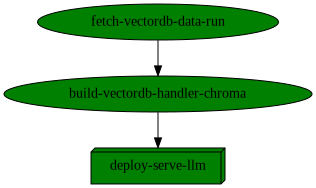

uid,start,state,name,parameters,results
...3abbfaf9,Jun 17 23:03:44,completed,build-vectordb-handler-chroma,cache_dir=/v3io/projects/genai-tutorial-new/artifacts/cache,
...a726980f,Jun 17 23:02:17,completed,fetch-vectordb-data-run,data_set=https://s3.wasabisys.com/iguazio/data/genai-tutorial/labelled_newscatcher_dataset.csv,


In [28]:
run_id = project.run(
    "main", arguments={"cache_dir": CACHE_DIR, "data_set": DATA_SET}, watch=True
)